In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

### Mecab 설치

In [2]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git


Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.


In [3]:
ls

drive/  Mecab-ko-for-Google-Colab/  sample_data/


In [5]:
cd Mecab-ko-for-Google-Colab/

/content/Mecab-ko-for-Google-Colab


In [6]:
ls

images/                                    LICENSE
install_mecab-ko_on_colab190912.sh         README.md
install_mecab-ko_on_colab_light_210108.sh


In [ ]:
! bash install_mecab-ko_on_colab190912.sh

In [9]:
# mecab 테스트하기
from konlpy.tag import Mecab
mecab = Mecab()
text = u"""colab에서 mecab테스트 중입니다!"""
mecab.morphs(text)

['colab', '에서', 'mecab', '테스트', '중', '입니다', '!']

### 필요한 라이브러리들 설치
- keras/tensorflow
- numpy, pandas, matplotlib
- sklearn

In [ ]:
!pip install tensorflow
!pip install keras


In [11]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

2.4.3
2.4.1


In [12]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn

#### 라이브러리 import

In [47]:

import os, json, glob, sys
import pandas as pd
import numpy as np
from keras.utils import np_utils
import matplotlib.pyplot as plt
import matplotlib as mpl

import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Flatten, Dropout, Input, Conv1D, MaxPooling1D, GlobalMaxPool1D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

from konlpy.tag import Mecab
mecab = Mecab()


#### Dataset 불러오기

In [15]:
path = "/content/drive/MyDrive/STT_/web_crawling/"
file_list = os.listdir(path)
names = [file[:-4] for file in file_list]
names

['속담',
 '교양영어사전',
 '기독교',
 '불교',
 '동양_철학_윤리',
 '한국_민속',
 '서양_철학_윤리',
 '심리',
 '무기',
 '기계_자동차_금속',
 '건설_토목',
 'IT',
 '댄스_무용',
 '만화',
 '미술',
 '명화',
 '영미문학',
 '일본문학',
 '중국문학',
 '한국문학',
 '이슬람교',
 '한국_철학_윤리',
 '기타종교',
 '교양_인문',
 '질병',
 '의학',
 '약학',
 '공예',
 '건축물',
 '환경',
 '농학',
 '클래식',
 '음악사',
 '악기',
 '아시아_역사_문화',
 '유럽_역사_문화',
 '아시아',
 '한국',
 '뮤지컬',
 '드라마',
 '영화',
 '색채',
 '중동_역사_문화',
 '음악용어',
 '세계_역사_문화',
 '한국_역사_문화',
 '북아메리카',
 '중동',
 '남아메리카',
 '유럽',
 '무역',
 '호텔',
 '부동산',
 '사회복지',
 '독일문학',
 '북한문학',
 '세계문학',
 '프랑스문학',
 '천문학',
 '수학',
 '물리학',
 '지구과학',
 '재료',
 '커피_차',
 '세계음식',
 '주류',
 '기업_브랜드',
 '인테리어',
 '육아',
 '헤어',
 '행정_기

In [16]:
df = pd.DataFrame(columns=['topic', 'sub_topic', 'contents', 'label'])

idx = 0
topic_index = dict()
for name in names:
    temp_df = pd.read_csv(path+"/"+name+'.csv', encoding= 'cp949', names=['url', 'sub_topic', 'contents'])
    len_ = len(temp_df)
    temp_df['topic'] = [name]*len_
    temp_df['label'] = [idx]*len_
    temp_df = temp_df.loc[:, ['topic', 'sub_topic', 'contents','label']]
    df = pd.concat([df, temp_df])
    topic_index[name] = idx
    idx += 1
    del temp_df
df

,topic,sub_topic,contents,label
0,속담,목구멍이포도청이다,먹고살기 매우 어려워지면 자기도 모르는 순간 죄를 범하게 되어 포도청에 잡혀가게 된...,0
1,속담,구관이명관이다,무슨 일이든 경험이 많은 사람이 잘 한다는 말이에요. 또 나중 사람을 겪어 봄으로써...,0
2,속담,닭쫓던개지붕쳐다본다,닭을 쫓던 개가 닭이 지붕으로 올라가자 쫓아 올라가지 못하고 지붕만 쳐다본다는 말....,0
3,속담,가는날이장날,어떤 일을 하려고 하다가 뜻하지 않게 공교로운 일을 만났을 때 하는 말이에요. 가는...,0
4,속담,미운놈떡하나더준다,미울수록 매 대신 떡을 준다는 말로 미운 사람일수록 잘 해 주고 생각하는 체라도 하...,0
...,...,...,...,...
9391,생명과학,말로닐CoA,지방산생합성에 의해 생성되는 기질 . 이 물질은 주로 아세틸CoA 카르복시화효소에 ...,90
9392,생명과학,역유전학,종래와 반대의 순서를 이용한 해석에 근거하는 유전학의 1분야. 즉 종래의 방법은 주...,90
9393,생명과학,호모시스틴뇨증,시스타티오닌 생성효소의 결손으로 메티오닌 호모시스틴 그의 중합체인 호모시스틴이 축적...,90
9394,생명과학,산화적인산화반응,호기적 생물의 주요한 ATP 공급반응으로 유기물을 분자상 산소에 의해 산화하여 얻어...,90


In [17]:
# 데이터 섞기
df_shuffled=df.sample(frac=1).reset_index(drop=True)
df_shuffled.head()

,topic,sub_topic,contents,label
0,주류,연엽주증보산림경제,술독 밑에 고인 맑은 청주는 대략 2컵 정도의 소량이었다. 술독 밑바닥에 고인 청...,65
1,서양_철학_윤리,정신의본성,9에서 아리스토텔레스는 7에서는 간략하게만 다루어졌던 정신 nous 에 대해 좀 ...,6
2,농학,오리아플라톡신중독증,곰팡이류는 의학적으로 중요한 대사산물 항생제등을 생산하는 반면 사람과 동물에 심한 ...,30
3,만화,고스트메신저,귀신을 보는 무당 소년 강림은 우연히 핸드폰을 손에 넣는다. 강림은 핸드폰을 통해...,13
4,한국_민속,대전외삼동산신제,대전광역시 유성구 외삼동에서 3년에 한 번 음력 시월 초순에 길일을 택해 마을 뒷산...,5


In [18]:
# 데이터 셋 크기
len(df)

386367

#### Data preprocessing

In [19]:
# 데이터 셋을 input, output구별
X = df_shuffled.loc[:, 'contents'].values
Y = df_shuffled.loc[:, 'label'].values

In [25]:
topic_index

{'IT': 11,
 '건설_토목': 10,
 '건축물': 28,
 '게임': 71,
 '경제': 78,
 '곤충': 86,
 '공예': 27,
 '교양_인문': 23,
 '교양영어사전': 1,
 '국제기구': 85,
 '군사': 89,
 '기계_자동차_금속': 9,
 '기독교': 2,
 '기업_브랜드': 66,
 '기타종교': 22,
 '남아메리카': 48,
 '농학': 30,
 '댄스_무용': 12,
 '독일문학': 54,
 '동물': 84,
 '동양_철학_윤리': 4,
 '드라마': 39,
 '만화': 13,
 '명화': 15,
 '무기': 8,
 '무역': 50,
 '물리학': 60,
 '뮤지컬': 38,
 '미술': 14,
 '바둑': 80,
 '법': 73,
 '부동산': 52,
 '북아메리카': 46,
 '북한문학': 55,
 '불교': 3,
 '사회복지': 53,
 '색채': 41,
 '생명과학': 90,
 '서양_철학_윤리': 6,
 '세계_역사_문화': 44,
 '세계문학': 56,
 '세계음식': 64,
 '속담': 0,
 '수학': 59,
 '식물': 83,
 '심리': 7,
 '아시아': 36,
 '아시아_역사_문화': 34,
 '아프리카': 76,
 '악기': 33,
 '약학': 26,
 '영미문학': 16,
 '영화': 40,
 '오세아니아': 82,
 '외교': 72,
 '유럽': 49,
 '유럽_역사_문화': 35,
 '육아': 68,

In [29]:
unique_elements, counts_elements = np.unique(Y, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
  27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
  51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
  75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90]
 [282 1003 9530 9294 3811 6098 9960 9628 5444 7652 10005 7398 3275 4854
  6403 9690 637 1045 9050 9442 75 1006 4545 3564 4622 9406 10005 949 2826
  3268 9095 1001 1265 1375 2439 4231 9963 9991 318 594 1499 1417 2527
  5588 7559 9786 1520 1479 2576 9922 1893 1706 2721 4665 942 488 7276
  1009 502 2073 2449 4418 1072 2837 6413 9737 3848 1711 392 341 1525 661
  1278 3858 6681 1542 1346 2588 3118 9447 2104 4504 369 5834 389 357 1522
  8052 9875 6516 9396]]


<BarContainer object of 91 artists>

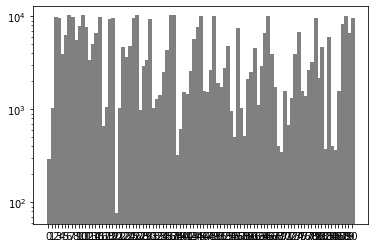

In [30]:
plt.bar(unique_elements, counts_elements, width=0.3, align='edge', color="blue",
        edgecolor="gray", linewidth=3, tick_label=unique_elements, log=True)

In [32]:
print(len(X))
print(len(Y))

386367
386367


In [33]:
# stop word 불러오기
path = '/content/drive/MyDrive/STT_/korean_stopwords.txt'
f = open(path, 'r', encoding='utf-8')
stop_words = []
while True:
    line = f.readline()
    if not line: break
    stop_words.append(line.split()[0])
f.close()

In [34]:
stop_words[:5]

['이', '있', '하', '것', '들']

In [37]:
new_X = []
delete_Y_idxs = []
for idx in range(len(X)):
  # 1. 토큰화
  temp = mecab.morphs(X[idx])
  # 2. 불용어 제거
  temp = [i for i in temp if i not in stop_words and i != '.']
  if temp:
      new_X.append(temp)
  else:
    delete_Y_idxs.append(idx)


In [38]:
print(len(new_X))
print(len(X))
print(len(delete_Y_idxs))


385030
386367
1337


In [40]:
# 필요없는 부분 제거
new_Y = np.delete(Y, delete_Y_idxs)
print(len(new_X))
print(len(X))
print(len(new_Y))
print(len(Y))

385030
386367
385030
386367


In [45]:
new_X[4]

['대전광역시',
 '유성구',
 '외삼동',
 '에서',
 '3',
 '에',
 '음력',
 '시월',
 '초순',
 '에',
 '길일',
 '을',
 '택해',
 '마을',
 '뒷산',
 '에서',
 '지내',
 '는',
 '산신제',
 '대전',
 '유성구',
 '외삼동',
 '은',
 '진주',
 '강',
 '경주',
 '김',
 '은진',
 '송',
 '거주',
 '는',
 '마을',
 '다',
 '자연',
 '마을',
 '로',
 '는',
 '산막',
 '서당',
 '골',
 '큰',
 '학교',
 '다',
 '과',
 '큰',
 '서당',
 '골',
 '일부',
 '옛날',
 '부터',
 '공동',
 '으로',
 '산제',
 '를',
 '지내',
 '왔',
 '다',
 '다가',
 '1992',
 '부터',
 '산제',
 '에',
 '참가',
 '게',
 '면서',
 '이후',
 '큰',
 '과',
 '서당',
 '골',
 '일부',
 '주민',
 '함께',
 '제',
 '를',
 '모시',
 '고',
 '다',
 '제',
 '를',
 '지내',
 '는',
 '곳',
 '은',
 '마을',
 '뒷산',
 '다',
 '산',
 '은',
 '밥',
 '봉',
 '275',
 'm',
 '의',
 '개울',
 '건너',
 '에',
 '는',
 '옆',
 '산',
 '으로',
 '계룡산',
 '의',
 '지맥',
 '기',
 '도',
 '다',
 '마을',
 '에서',
 '는',
 '특이',
 '게',
 '도',
 '상당',
 '제',
 '로서',
 '칠성당',
 '과',
 '산신제',
 '를',
 '나누',
 '어',
 '지낸다',
 '뒷산',
 '꼭대기',
 '에',
 '는',
 '칠성당',
 '라는',
 '큰',
 '바위',
 '고',
 '밑',
 '에',
 '제물',
 '을',
 '차릴',
 '게',
 '막돌',
 '로',
 '단',
 '을',
 '쌓',
 '아',
 '았',
 '다',
 '칠',
 '성당',
 '못',
 '미쳐서',
 '감나무',

In [48]:
# X 정수 encoding하기
max_word = 10000
max_len = 1000 #max_len = 500

tok = Tokenizer(num_words = max_word)
tok.fit_on_texts(new_X)
sequences = tok.texts_to_sequences(new_X)
print(len(tok.word_index))

418293


각 기사의 단어 수가 제각각 다르므로 이를 동일하게 맞춰야 한다.
이때는 다음과 같이 데이터 전처리 함수 sequence()를 이용한다.

In [51]:
sequences_matrix  = sequence.pad_sequences(sequences, maxlen=max_len)
print(sequences_matrix)
print(len(sequences_matrix[0]))

[[   0    0    0 ... 6517    3    5]
 [   0    0    0 ...    1 4242    5]
 [   0    0    0 ...    6  650    5]
 ...
 [   0    0    0 ...  829    2 1685]
 [   0    0    0 ... 8377   53    5]
 [   0    0    0 ...   19 2802    5]]
1000


In [56]:
type(sequences_matrix)

numpy.ndarray

In [53]:
type(new_Y)

numpy.ndarray

In [55]:
print(len(sequences_matrix))

385030


In [60]:
# new_Y 데이터에 원-핫 인코딩 처리를 하여 데이터 전처리 과정을 마친다.
nb_classes = len(set(new_Y))
print(nb_classes)
y = np_utils.to_categorical(new_Y, nb_classes)


91


In [62]:
print(y[100])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [63]:
X_train, X_test, y_train, y_test = train_test_split(sequences_matrix, y, test_size=0.2)

In [64]:
print(X_train.shape)
print(y_train.shape)

(308024, 1000)
(308024, 91)


In [65]:
print(X_test.shape)
print(y_test.shape)

(77006, 1000)
(77006, 91)


##### training set X : 308024, 1000
##### training set Y : 308024, 91

##### training set X : 77006, 1000
##### training set Y : 77006, 91

### Model 설계 및 훈련

In [66]:
model = Sequential()

model.add(Embedding(max_word, 64, input_length=max_len))
model.add(LSTM(60, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [70]:
model_dir = '/content/drive/MyDrive/STT_/model'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
model_path = model_dir + "/Naver_dict_lstm.h5"

In [71]:
model_path

'/content/drive/MyDrive/STT_/model/Naver_dict_lstm.h5'

In [73]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
mc = ModelCheckpoint(filepath=model_path, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [74]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 64)          640000    
_________________________________________________________________
lstm (LSTM)                  (None, 1000, 60)          30000     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 91)                4

In [ ]:
history = model.fit(X_train, y_train, batch_size=256, epochs=50, callbacks=[es, mc], validation_split=0.2)

Epoch 1/50
963/963 [==============================] - ETA: 0s - loss: 3.7173 - accuracy: 0.1117

In [ ]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

In [ ]:
y_vloss = hist.history['val_loss']
y_loss = hist.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [ ]:
y_vloss = hist.history['val_acc']
y_loss = hist.history['acc']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [ ]:
str = ['''이번 시간에는 문화의 정의와 구분 방식, 문화의 유동성과 통번역과의 관계를 학습하겠습니다.
또 통번역의 역사적인 발전과 중요성을 세계사와 국내 역사의 관점에서 살펴본 다음,
통번역과 국가경쟁력, 또 통번역과 개개인의 경쟁력 간의 관계를 알아보겠습니다.
그럼 우리가 함께 살펴볼 첫 번째 개념이 문화입니다. 이 어휘는 실생활에서 우리가 너무 흔하게 접하기 때문에 의미를 크게 깊이 생각하지 않고 사용하는 어휘 가운데 하나입니다.
우리가 대체로 한국문화, 미국문화, 중국문화와 같이 특정 집단 사람들이 공유하는 특징적인 삶의 방식이나 지식을 가리키는 데 사용하죠.
여기에는 언어, 정치, 경제, 종교, 예술 같은 것은 물론이고 음식이나 혼례방식, 장례방식 같은 사회적인 관습도 포함됩니다.
학자들은 가시적으로 볼 수 없는 정신이나 가치를 문화라고 부르는 데 비해서 건축이나 예술, 테크놀로지 같은 것은 문명으로 구분하는 경향이 있습니다.
그러면 문화라는 단어의 어원은 어디에 있을까요? 문화를 뜻하는 영어 어휘는 ‘culture’인데 이 어휘의 어원이 라틴어의 ‘colere’입니다. 즉, 땅을 돌보고 길러낸다는 의미죠.
이렇게 볼 때 문화라는 것은 인간이 발 디디고 생활하는 환경을 좀 더 좋게 바꿔나가는 모든 과정 또는 그것의 결과물을 가리킨다고 생각할 수 있겠습니다.
문화의 특징은 크게 두 가지인데, 첫 번째로는 특정 집단과 다른 집단을 구분 지어주는 역할을 한다는 것.
그리고 두 번째로는 특정 집단의 가치와 사고방식을 집단적으로 학습하는 과정. 곧 사회화를 통해서 구성원들이 공유하게 된다는 점입니다.
우리가 문화를 다양한 방식으로 구분할 수 있는데요. 고대문명의 발상지를 기준으로 할 때는 이집트문명, 갠지스문명, 메소포타미아문명 이렇게 구분하기도 하고요.
아시아문화, 유럽문화와 같이 문화가 분포하는 지리적인 특성이나 인종에 따라 구분하기도 합니다.
또 향유주체, 즉 문화를 누리는 사람이 누군가에 따라서 대중문화냐, 고급문화냐를 구분하거나 조직문화냐, 개인 문화냐와 같이 다양한 관점에 따라 분류하기도 합니다.
여기에서 주목할 것은 문화의 속성이 끊임없는 변화와 유동성이라는 거죠.
학자들은 문화가 단 한 번도 고정되어 있거나 정형화된 채로 머물러 있지 않고 본질적으로 끊임없이 변화한다고 강조합니다. 
''']
sequences_6m = tok.texts_to_sequences(str)
print(sequences_6m)
sequences_matrix_6m = sequence.pad_sequences(sequences_6m, maxlen=500)
model.predict_classes(sequences_matrix_6m)